In [49]:
import os
import soundfile as sf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ast import literal_eval
from main_2 import conditioning_signal, get_mixed_signal, nmf_process
from utils import signal_segmentation, find_segments_limits
from process_functions import preprocessing_audio
from heart_sound_segmentation.filter_and_sampling import downsampling_signal,\
     upsampling_signal, resampling_by_points
from source_separation.nmf_decompositions import nmf_decomposition
from source_separation.descriptor_functions import get_spectrogram
from source_separation.evaluation_metrics import get_PSD

In [2]:
samplerate_des = 11025
model_name = 'definitive_segnet_based'
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}

# Definición de la dirección de la base de datos de sonidos resp
db_resp = '_beta_cardiorespiratory_database/Resp_Sounds'
# Definición de la dirección de la base de datos de sonidos cardiacos
db_heart = '_beta_cardiorespiratory_database/Heart_Sounds'

# Archivos .wav de la carpeta
resp_filenames = [i for i in os.listdir(db_resp) if i.endswith('.wav')]
heart_filenames = [i for i in os.listdir(db_heart) if i.endswith('.wav')]

# Plots acondicionamiento señal cardiaca

SNR obtained = 9.64327466553287e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step


<IPython.core.display.Javascript object>


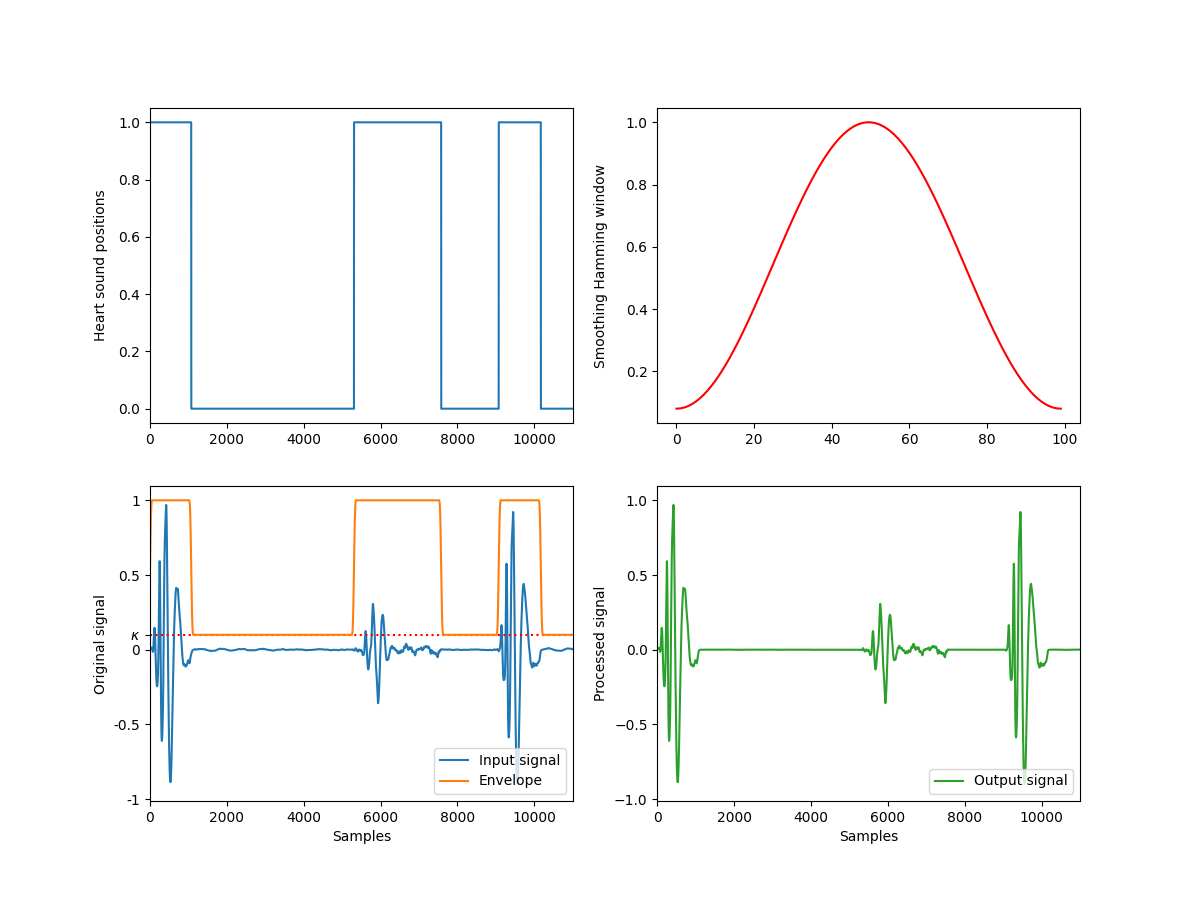

In [6]:
def conditioning_heart_sound(signal_index, nmf_parameters, snr_expected,
                     nmf_method='masked_segments', print_metrics=False,
                     base_factor= 0.05, N_wind=100, plot_segmentation=False, 
                     plot_separation=False):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    ######### Import de archivos de audio #########
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Clasificando
    _, y_hat_to, (y_out2, _, _) = \
        signal_segmentation(heart_to, samplerate_des, model_name,
                            length_desired=len(mixed_to), 
                            lowpass_params=lowpass_params, 
                            plot_outputs=False)
    
    # Definiendo la lista de intervalos
    interval_list = find_segments_limits(y_out2, segments_return='Heart')
    
    if plot_segmentation:
        fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
        mixed_to_plot = mixed_to / max(abs(mixed_to))
        audio_data_plot = 0.5 * mixed_to_plot / max(abs(mixed_to_plot))
        ax[0].plot(audio_data_plot - min(audio_data_plot), label=r'$s(n)$', 
                 color='silver', zorder=0)
        ax[0].plot(y_hat_to[0,:,0], label=r'$S_0$', color='limegreen', zorder=2)
        ax[0].plot(y_hat_to[0,:,1], label=r'$S_1$', color='red', zorder=1)
        ax[0].plot(y_hat_to[0,:,2], label=r'$S_2$', color='blue', zorder=1)
        ax[0].legend(loc='lower right')
        ax[0].set_yticks([0, 0.5, 1])
        ax[0].set_ylabel(r'$P(y(n) = k | X)$')

        ax[1].plot(y_out2)

        plt.show()
        
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    
    # Interactivo
    fig, ax = plt.subplots(2, 2, figsize=(12, 9), sharex=False)
    ax[0][0].plot(y_out2, label='Posiciones sonidos cardiacos')
    ax[0][0].set_xlim([0, 11000])
    ax[0][0].set_ylabel('Posición de sonidos cardiacos')
    
    ax[0][1].plot(np.hamming(N_wind), color='red', label='Ventana Hamming')
    ax[0][1].set_ylabel('Ventana Hamming de suavizado')
    
    ax[1][0].plot(heart_to, label='Señal de entrada', zorder=0)
    ax[1][0].plot(conv_sign, label='Envolvente', zorder=2)
    ax[1][0].axhline(0.1, color='red', linestyle='dotted', zorder=1)
    ax[1][0].legend(loc='lower right')
    ax[1][0].set_xlim([0, 11000])
    ax[1][0].set_yticks([-1, -0.5, 0, 0.1, 0.5, 1])
    ax[1][0].set_yticklabels([-1, -0.5, 0, r'$\kappa$', 0.5, 1])
    ax[1][0].set_ylabel('Señal original')
    ax[1][0].set_xlabel('Muestras')
    
    ax[1][1].plot(heart_to * conv_sign, color='C2', label='Señal de salida')
    ax[1][1].set_xlim([0, 11000])
    ax[1][1].legend(loc='lower right')
    ax[1][1].set_yticks([-1, -0.5, 0, 0.5, 1])
    ax[1][1].set_ylabel('Señal procesada')
    ax[1][1].set_xlabel('Muestras')
    
    fig.align_ylabels(ax[:])
    plt.savefig('Images/Heart_sound_conditioning_SPA.pdf', transparent=True)
    plt.show()


def conditioning_heart_sound_spa(signal_index, nmf_parameters, snr_expected,
                     nmf_method='masked_segments', print_metrics=False,
                     base_factor= 0.05, N_wind=100, plot_segmentation=False, 
                     plot_separation=False):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    ######### Import de archivos de audio #########
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Clasificando
    _, y_hat_to, (y_out2, _, _) = \
        signal_segmentation(heart_to, samplerate_des, model_name,
                            length_desired=len(mixed_to), 
                            lowpass_params=lowpass_params, 
                            plot_outputs=False)
    
    # Definiendo la lista de intervalos
    interval_list = find_segments_limits(y_out2, segments_return='Heart')
    
    if plot_segmentation:
        fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
        mixed_to_plot = mixed_to / max(abs(mixed_to))
        audio_data_plot = 0.5 * mixed_to_plot / max(abs(mixed_to_plot))
        ax[0].plot(audio_data_plot - min(audio_data_plot), label=r'$s(n)$', 
                 color='silver', zorder=0)
        ax[0].plot(y_hat_to[0,:,0], label=r'$S_0$', color='limegreen', zorder=2)
        ax[0].plot(y_hat_to[0,:,1], label=r'$S_1$', color='red', zorder=1)
        ax[0].plot(y_hat_to[0,:,2], label=r'$S_2$', color='blue', zorder=1)
        ax[0].legend(loc='lower right')
        ax[0].set_yticks([0, 0.5, 1])
        ax[0].set_ylabel(r'$P(y(n) = k | X)$')

        ax[1].plot(y_out2)

        plt.show()
        
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    
    # Interactivo
    fig, ax = plt.subplots(2, 2, figsize=(12, 9), sharex=False)
    ax[0][0].plot(y_out2, label='Heart sound positions')
    ax[0][0].set_xlim([0, 11000])
    ax[0][0].set_ylabel('Heart sound positions')
    
    ax[0][1].plot(np.hamming(N_wind), color='red', label='Ventana Hamming')
    ax[0][1].set_ylabel('Smoothing Hamming window')
    
    ax[1][0].plot(heart_to, label='Input signal', zorder=0)
    ax[1][0].plot(conv_sign, label='Envelope', zorder=2)
    ax[1][0].axhline(0.1, color='red', linestyle='dotted', zorder=1)
    ax[1][0].legend(loc='lower right')
    ax[1][0].set_xlim([0, 11000])
    ax[1][0].set_yticks([-1, -0.5, 0, 0.1, 0.5, 1])
    ax[1][0].set_yticklabels([-1, -0.5, 0, r'$\kappa$', 0.5, 1])
    ax[1][0].set_ylabel('Original signal')
    ax[1][0].set_xlabel('Samples')
    
    ax[1][1].plot(heart_to * conv_sign, color='C2', label='Output signal')
    ax[1][1].set_xlim([0, 11000])
    ax[1][1].legend(loc='lower right')
    ax[1][1].set_yticks([-1, -0.5, 0, 0.5, 1])
    ax[1][1].set_ylabel('Processed signal')
    ax[1][1].set_xlabel('Samples')
    
    fig.align_ylabels(ax[:])
    plt.savefig('Images/Heart_sound_conditioning.pdf', transparent=True)
    plt.show()


    
nmf_parameters = {'n_components': 5, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}

signal_index = 11
%matplotlib notebook
# a = conditioning_heart_sound(signal_index, nmf_parameters, snr_expected=0, 
#                              nmf_method='to_all', plot_segmentation=False, 
#                              plot_separation=True, base_factor=0.1, N_wind=100)

a = conditioning_heart_sound_spa(signal_index, nmf_parameters, snr_expected=0, 
                             nmf_method='to_all', plot_segmentation=False, 
                             plot_separation=True, base_factor=0.1, N_wind=100)

# Gráfico NMF sobre segmentos

7 normal__201103090635.wav 7 2 135_2b3_Al_mc_LittC2SE.wav
SNR obtained = 9.64327466553287e-16 dB


<IPython.core.display.Javascript object>


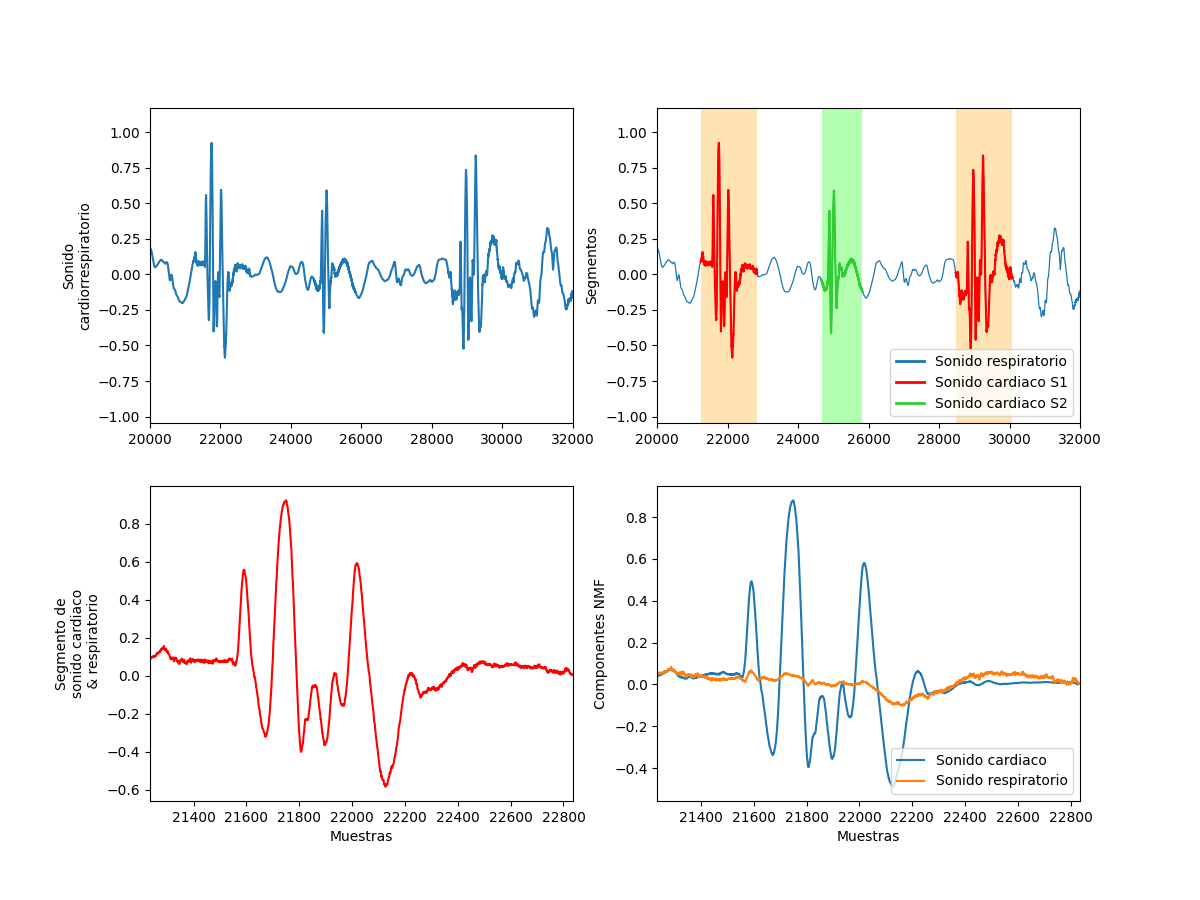

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:359: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:363: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:359: MatplotlibDeprecationWarning: Adding an axes us

In [8]:
def graphic_nmf_on_segments(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    

    ######### Separación de fuentes #########
    # Separando
    resp_pred, heart_pred = \
                nmf_process(mixed_to, samplerate_des, hs_pos=y_out2, 
                            interval_list=interval_list, 
                            nmf_parameters=nmf_parameters,
                            filter_parameters=filter_parameters, 
                            nmf_method=nmf_method)
    # Cortando
    low_limit = 20000
    up_limit = 32000
    audio_short = mixed_to
    
    plt.figure(figsize=(12,9))
    
    plt.subplot(2,2,1)
    plt.plot(audio_short)
    plt.ylabel('Heart &\nlung sound')
    plt.xlim([low_limit, up_limit])
    
    plt.subplot(2,2,2)
    plt.plot(audio_short, linewidth=0.9, label='Respiratory sound')
    plt.xlim([low_limit, up_limit])
    
    # Definición de base para sonido respiratorio
    resp_sound = np.copy(audio_short)
    # Definición de base para sonido cardiaco
    heart_sound = np.zeros(len(audio_short))

    for num, i in enumerate(interval_list):
        if i[0] >= up_limit or i[1] >= up_limit:
            break
            
        if i[0] <= low_limit or i[1] <= low_limit:
            continue

        # Definición del intervalo
        x = np.arange(i[0], i[1])

        # Eliminación del segmento para el plot 3
        resp_sound[x] = 0

        # Agregando sonido cardiaco para el plot 4
        heart_sound[x] = audio_short[x]


    for num, i in enumerate(interval_list):
        if i[0] >= up_limit or i[1] >= up_limit:
            break
            
        if i[0] <= low_limit or i[1] <= low_limit:
            continue

        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'

        # Rango en el que ploteará la señal
        x = np.arange(i[0], i[1])
        x1 = np.arange(i[0]-1, i[1]+1)

        plt.subplot(2,2,2)
        plt.plot(x, audio_short[x], c=c_plot, linewidth=1.5)

        # Destacando toda la sección
        plt.subplot(2,2,2)
        plt.axvspan(i[0], i[1] , facecolor=c_span, alpha=0.3)
    
    # Creación de la leyenda
    plt.subplot(2,2,2)
    plt.legend(handles=[Line2D([0], [0], color='C0', lw=2, label='Respiratory sound'),
                        Line2D([0], [0], color='r', lw=2, label='S1 heart sound'),
                        Line2D([0], [0], color='limegreen', lw=2, label='S2 heart sound')],
                loc='lower right')
    plt.ylabel('Segments')

    plt.subplot(2,2,3)
    x = np.arange(interval_list[6][0], interval_list[6][1])
    plt.plot(x, audio_short[x], c='r', linewidth=1.5)
    plt.xlabel('Samples')
    plt.ylabel('Heart &\nlung sound\nsegment')
    plt.xlim([x[0], x[-1]] )

    plt.subplot(2,2,4)
    plt.plot(x, heart_pred[x], label='Heart sound')
    plt.plot(x, resp_pred[x], label='Respiratory sound')
    plt.xlabel('Samples')
    plt.ylabel('NMF Components')
    plt.legend(loc='lower right')
    plt.xlim([x[0], x[-1]] )
    
    plt.savefig('Images/Heart_sound_segments.pdf', transparent=True)
    
    plt.show()
    

def graphic_nmf_on_segments_spa(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    

    ######### Separación de fuentes #########
    # Separando
    resp_pred, heart_pred = \
                nmf_process(mixed_to, samplerate_des, hs_pos=y_out2, 
                            interval_list=interval_list, 
                            nmf_parameters=nmf_parameters,
                            filter_parameters=filter_parameters, 
                            nmf_method=nmf_method)
    # Cortando
    low_limit = 20000
    up_limit = 32000
    audio_short = mixed_to
    
    plt.figure(figsize=(12,9))
    
    plt.subplot(2,2,1)
    plt.plot(audio_short)
    plt.ylabel('Sonido\ncardiorrespiratorio')
    plt.xlim([low_limit, up_limit])
    
    plt.subplot(2,2,2)
    plt.plot(audio_short, linewidth=0.9, label='Sonido respiratorio')
    plt.xlim([low_limit, up_limit])
    
    # Definición de base para sonido respiratorio
    resp_sound = np.copy(audio_short)
    # Definición de base para sonido cardiaco
    heart_sound = np.zeros(len(audio_short))

    for num, i in enumerate(interval_list):
        if i[0] >= up_limit or i[1] >= up_limit:
            break
            
        if i[0] <= low_limit or i[1] <= low_limit:
            continue

        # Definición del intervalo
        x = np.arange(i[0], i[1])

        # Eliminación del segmento para el plot 3
        resp_sound[x] = 0

        # Agregando sonido cardiaco para el plot 4
        heart_sound[x] = audio_short[x]


    for num, i in enumerate(interval_list):
        if i[0] >= up_limit or i[1] >= up_limit:
            break
            
        if i[0] <= low_limit or i[1] <= low_limit:
            continue

        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'

        # Rango en el que ploteará la señal
        x = np.arange(i[0], i[1])
        x1 = np.arange(i[0]-1, i[1]+1)

        plt.subplot(2,2,2)
        plt.plot(x, audio_short[x], c=c_plot, linewidth=1.5)

        # Destacando toda la sección
        plt.subplot(2,2,2)
        plt.axvspan(i[0], i[1] , facecolor=c_span, alpha=0.3)
    
    # Creación de la leyenda
    plt.subplot(2,2,2)
    plt.legend(handles=[Line2D([0], [0], color='C0', lw=2, label='Sonido respiratorio'),
                        Line2D([0], [0], color='r', lw=2, label='Sonido cardiaco S1'),
                        Line2D([0], [0], color='limegreen', lw=2, label='Sonido cardiaco S2')],
                loc='lower right')
    plt.ylabel('Segmentos')

    plt.subplot(2,2,3)
    x = np.arange(interval_list[6][0], interval_list[6][1])
    plt.plot(x, audio_short[x], c='r', linewidth=1.5)
    plt.xlabel('Muestras')
    plt.ylabel('Segmento de\nsonido cardiaco\n & respiratorio')
    plt.xlim([x[0], x[-1]] )

    plt.subplot(2,2,4)
    plt.plot(x, heart_pred[x], label='Sonido cardiaco')
    plt.plot(x, resp_pred[x], label='Sonido respiratorio')
    plt.xlabel('Muestras')
    plt.ylabel('Componentes NMF')
    plt.legend(loc='lower right')
    plt.xlim([x[0], x[-1]] )
    
    plt.savefig('Images/Heart_sound_segments_SPA.pdf', transparent=True)
    
    plt.show()

    

%matplotlib notebook
filter_parameters = {'bool': False , 'freq_pass': 980, 'freq_stop': 1000}
nmf_parameters = {'n_components': 2, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}
snr_expected = 0

signal_index = 7
# graphic_nmf_on_segments(signal_index, nmf_parameters, snr_expected, filter_parameters, 
#                         nmf_method='on_segments', print_metrics=False,
#                         base_factor= 0, N_wind=100, N_expand=30)
graphic_nmf_on_segments_spa(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                        nmf_method='on_segments', print_metrics=False,
                        base_factor= 0, N_wind=100, N_expand=30)

# Gráfico NMF segmentos enmascarados

7 normal__201103090635.wav 7 2 135_2b3_Al_mc_LittC2SE.wav
SNR obtained = 9.64327466553287e-16 dB


<IPython.core.display.Javascript object>


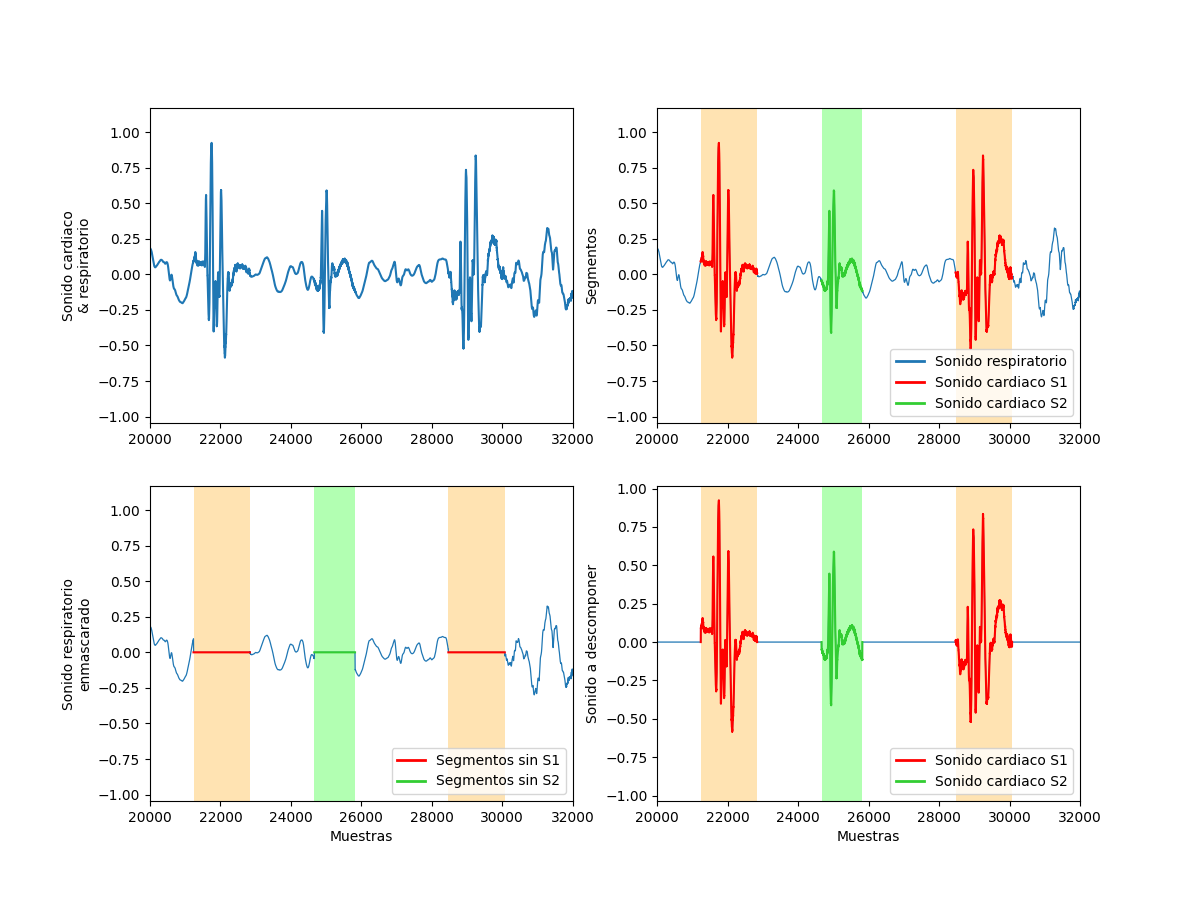

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:371: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:374: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:377: MatplotlibDeprecationWarning: Adding an axes us

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:377: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:381: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:384: MatplotlibDeprecationWarning: Adding an axes us

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:384: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:387: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:371: MatplotlibDeprecationWarning: Adding an axes us

In [11]:
def graphic_nmf_masked_segments(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    

    ######### Separación de fuentes #########
    # Separando
    resp_pred, heart_pred = \
                nmf_process(mixed_to, samplerate_des, hs_pos=y_out2, 
                            interval_list=interval_list, 
                            nmf_parameters=nmf_parameters,
                            filter_parameters=filter_parameters, 
                            nmf_method=nmf_method)
    
    low_limit = 20000
    up_limit = 32000
    audio_short = mixed_to

    plt.figure(figsize=(12,9))
    
    plt.subplot(2,2,1)
    plt.plot(audio_short)
    plt.ylabel('Heart &\nlung sound')
    plt.xlim([low_limit, up_limit])

    plt.subplot(2,2,2)
    plt.plot(audio_short, linewidth=0.9, label='Respiratory sound')
    plt.xlim([low_limit, up_limit])
    plt.ylabel('Segments')
    
    # Definición de base para sonido respiratorio
    resp_sound = np.copy(audio_short)
    # Definición de base para sonido cardiaco
    heart_sound = np.zeros(len(audio_short))

    for num, i in enumerate(interval_list):
        if i[0] >= up_limit or i[1] >= up_limit:
            break

        # Definición del intervalo
        x = np.arange(i[0], i[1])

        # Eliminación del segmento para el plot 3
        resp_sound[x] = 0

        # Agregando sonido cardiaco para el plot 4
        heart_sound[x] = audio_short[x]

    plt.subplot(2,2,3)
    plt.plot(resp_sound, linewidth=0.9)

    plt.subplot(2,2,4)
    plt.plot(heart_sound, linewidth=0.9)

    for num, i in enumerate(interval_list):
        if i[0] >= up_limit or i[1] >= up_limit:
            break

        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'

        # Rango en el que ploteará la señal
        x = np.arange(i[0], i[1])
        x1 = np.arange(i[0]-1, i[1]+1)

        plt.subplot(2,2,2)
        plt.plot(x, audio_short[x], c=c_plot, linewidth=1.5)

        plt.subplot(2,2,3)
        plt.plot(x, resp_sound[x], c=c_plot, linewidth=1.5)

        plt.subplot(2,2,4)
        plt.plot(x1, heart_sound[x1], c=c_plot, linewidth=1.5)

        # Destacando toda la sección
        plt.subplot(2,2,2)
        plt.axvspan(i[0], i[1], facecolor=c_span, alpha=0.3)

        plt.subplot(2,2,3)
        plt.axvspan(i[0], i[1], facecolor=c_span, alpha=0.3)

        plt.subplot(2,2,4)
        plt.axvspan(i[0], i[1], facecolor=c_span, alpha=0.3)

    # Creación de la leyenda
    plt.subplot(2,2,2)
    plt.legend(handles=[Line2D([0], [0], color='C0', lw=2, label='Respiratory sound'),
                        Line2D([0], [0], color='r', lw=2, label='S1 heart sound'),
                        Line2D([0], [0], color='limegreen', lw=2, label='S2 heart sound')],
                loc='lower right')

    plt.subplot(2,2,3)
    plt.xlabel('Samples')
    plt.ylabel('Masked\nrespiratory sound')
    plt.legend(handles=[Line2D([0], [0], color='r', lw=2, label='No S1 segments'),
                        Line2D([0], [0], color='limegreen', lw=2, label='No S2 segments')],
                loc='lower right')
    plt.xlim([low_limit, up_limit])

    plt.subplot(2,2,4)
    plt.xlabel('Samples')
    plt.ylabel('Heart sound')
    plt.legend(handles=[Line2D([0], [0], color='r', lw=2, label='S1 heart sound'),
                        Line2D([0], [0], color='limegreen', lw=2, label='S2 heart sound')],
                loc='lower right')
    plt.xlim([low_limit, up_limit])

    plt.savefig('Images/Heart_sound_masked_segments.pdf', transparent=True)
    plt.show()

    
def graphic_nmf_masked_segments_spa(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    

    ######### Separación de fuentes #########
    # Separando
    resp_pred, heart_pred = \
                nmf_process(mixed_to, samplerate_des, hs_pos=y_out2, 
                            interval_list=interval_list, 
                            nmf_parameters=nmf_parameters,
                            filter_parameters=filter_parameters, 
                            nmf_method=nmf_method)
    
    low_limit = 20000
    up_limit = 32000
    audio_short = mixed_to

    plt.figure(figsize=(12,9))
    
    plt.subplot(2,2,1)
    plt.plot(audio_short)
    plt.ylabel('Sonido cardiaco\n& respiratorio')
    plt.xlim([low_limit, up_limit])

    plt.subplot(2,2,2)
    plt.plot(audio_short, linewidth=0.9, label='Sonido respiratorio')
    plt.xlim([low_limit, up_limit])
    plt.ylabel('Segmentos')
    
    
    # Definición de base para sonido respiratorio
    resp_sound = np.copy(audio_short)
    # Definición de base para sonido cardiaco
    heart_sound = np.zeros(len(audio_short))

    for num, i in enumerate(interval_list):
        if i[0] >= up_limit or i[1] >= up_limit:
            break

        # Definición del intervalo
        x = np.arange(i[0], i[1])

        # Eliminación del segmento para el plot 3
        resp_sound[x] = 0

        # Agregando sonido cardiaco para el plot 4
        heart_sound[x] = audio_short[x]

    plt.subplot(2,2,3)
    plt.plot(resp_sound, linewidth=0.9)

    plt.subplot(2,2,4)
    plt.plot(heart_sound, linewidth=0.9)

    for num, i in enumerate(interval_list):
        if i[0] >= up_limit or i[1] >= up_limit:
            break

        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'

        # Rango en el que ploteará la señal
        x = np.arange(i[0], i[1])
        x1 = np.arange(i[0]-1, i[1]+1)

        plt.subplot(2,2,2)
        plt.plot(x, audio_short[x], c=c_plot, linewidth=1.5)

        plt.subplot(2,2,3)
        plt.plot(x, resp_sound[x], c=c_plot, linewidth=1.5)

        plt.subplot(2,2,4)
        plt.plot(x1, heart_sound[x1], c=c_plot, linewidth=1.5)

        # Destacando toda la sección
        plt.subplot(2,2,2)
        plt.axvspan(i[0], i[1], facecolor=c_span, alpha=0.3)

        plt.subplot(2,2,3)
        plt.axvspan(i[0], i[1], facecolor=c_span, alpha=0.3)

        plt.subplot(2,2,4)
        plt.axvspan(i[0], i[1], facecolor=c_span, alpha=0.3)

    # Creación de la leyenda
    plt.subplot(2,2,2)
    plt.legend(handles=[Line2D([0], [0], color='C0', lw=2, label='Sonido respiratorio'),
                        Line2D([0], [0], color='r', lw=2, label='Sonido cardiaco S1'),
                        Line2D([0], [0], color='limegreen', lw=2, label='Sonido cardiaco S2')],
                loc='lower right')

    plt.subplot(2,2,3)
    plt.xlabel('Muestras')
    plt.ylabel('Sonido respiratorio\nenmascarado')
    plt.legend(handles=[Line2D([0], [0], color='r', lw=2, label='Segmentos sin S1'),
                        Line2D([0], [0], color='limegreen', lw=2, label='Segmentos sin S2')],
                loc='lower right')
    plt.xlim([low_limit, up_limit])

    plt.subplot(2,2,4)
    plt.xlabel('Muestras')
    plt.ylabel('Sonido a descomponer')
    plt.legend(handles=[Line2D([0], [0], color='r', lw=2, label='Sonido cardiaco S1'),
                        Line2D([0], [0], color='limegreen', lw=2, label='Sonido cardiaco S2')],
                loc='lower right')
    plt.xlim([low_limit, up_limit])

    plt.savefig('Images/Heart_sound_masked_segments_SPA.pdf', transparent=True)
    plt.show()

    

%matplotlib notebook
filter_parameters = {'bool': False , 'freq_pass': 980, 'freq_stop': 1000}
nmf_parameters = {'n_components': 2, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}
snr_expected = 0

signal_index = 7
graphic_nmf_masked_segments(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                            nmf_method='masked_segments', print_metrics=False,
                            base_factor= 0, N_wind=100, N_expand=30)
# graphic_nmf_masked_segments_spa(signal_index, nmf_parameters, snr_expected, filter_parameters, 
#                                 nmf_method='masked_segments', print_metrics=False,
#                                 base_factor= 0, N_wind=100, N_expand=30)

# Gráfico del heart rate

7 normal__201103090635.wav 7 2 135_2b3_Al_mc_LittC2SE.wav
SNR obtained = 9.64327466553287e-16 dB


<IPython.core.display.Javascript object>


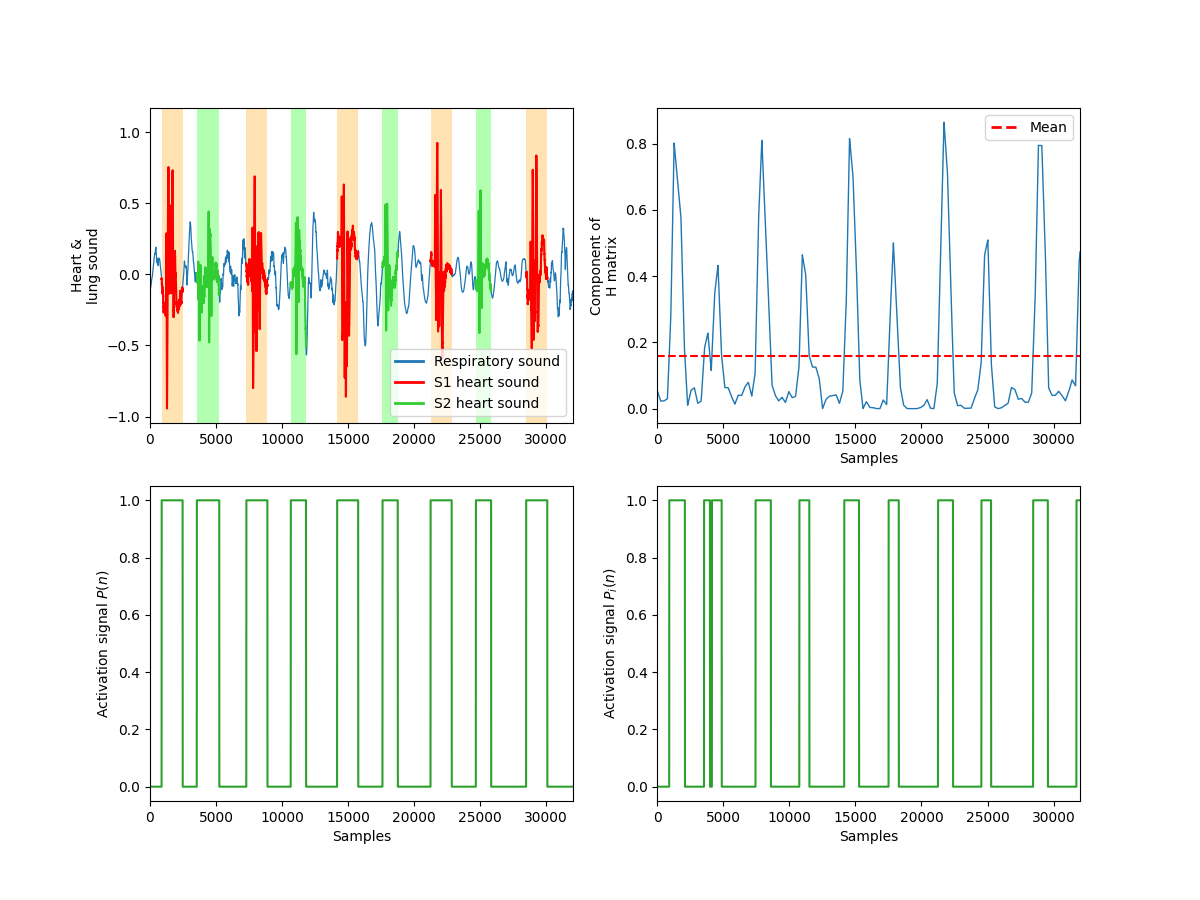

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:159: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:159: MatplotlibDeprecationWarning: Adding an axes us

In [28]:
def graphic_heart_rate(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    

    ######### Separación de fuentes #########
    # Separando
    components, Y_list, S, W, H = \
            nmf_decomposition(mixed_to, samplerate_des, n_components=2, N=1024, noverlap=768, 
                              iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                              filter_out='wiener', init='random', solver='mu', beta=2,
                              tol=1e-4, max_iter=1000, alpha_nmf=0, l1_ratio=0,
                              random_state=0, W_0=None, H_0=None, same_outshape=True,
                              plot_spectrogram=False, scale='abs', db_basys=1e-15)
    
    low_limit = 0
    up_limit = 32000
    audio_short = mixed_to

    plt.figure(figsize=(12, 9))
    plt.subplot(2,2,1)
    plt.plot(audio_short, linewidth=0.9, label='Respiratory sound')
    plt.ylabel('Heart &\nlung sound')
    plt.xlim([low_limit, up_limit])
    plt.yticks([-1, -0.5, 0, 0.5, 1])

    # Definición de base para sonido respiratorio
    resp_sound = np.copy(audio_short)
    # Definición de base para sonido cardiaco
    heart_sound = np.zeros(len(audio_short))

    # Señal p
    p_signal = np.zeros(len(audio_short))

    for num, i in enumerate(interval_list):
        lower = i[0]
        upper = i[1]

        if lower >= up_limit or upper >= up_limit:
            break

        # Definición del intervalo
        x = np.arange(lower, upper)

        # Eliminación del segmento para el plot 3
        p_signal[x] = 1


    for num, i in enumerate(interval_list):
        lower = i[0]
        upper = i[1]

        if lower >= up_limit or upper >= up_limit:
            break

        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'

        # Rango en el que ploteará la señal
        x = np.arange(lower, upper)
        x1 = np.arange(i[0]-1, i[1]+1)

        plt.subplot(2,2,1)
        plt.plot(x, audio_short[x], c=c_plot, linewidth=1.5)

        # Destacando toda la sección
        plt.subplot(2,2,1)
        plt.axvspan(lower, upper, facecolor=c_span, alpha=0.3)

    # Creación de la leyenda
    plt.subplot(2,2,1)
    plt.legend(handles=[Line2D([0], [0], color='C0', lw=2, label='Respiratory sound'),
                        Line2D([0], [0], color='r', lw=2, label='S1 heart sound'),
                        Line2D([0], [0], color='limegreen', lw=2, label='S2 heart sound')],
                loc='lower right')


    # Resampleando el patron temporal
    h_final = resampling_by_points(H[0], 1, len(mixed_to))

    plt.subplot(2,2,2)
    plt.plot(h_final[:up_limit], c='C0', linewidth=1)
    plt.axhline(h_final.mean(), linestyle='--', color='r')
    plt.xlabel('Samples')
    plt.ylabel('Component of\nH matrix')
    plt.legend(handles=[Line2D([0], [0], linestyle='--', color='r', lw=2, label='Mean')],
                loc='upper right')
    plt.xlim([low_limit, up_limit])

    # Definición de base para sonido respiratorio
    resp_sound = np.copy(audio_short)
    # Definición de base para sonido cardiaco
    heart_sound = np.zeros(len(audio_short))


    plt.subplot(2,2,3)
    plt.plot(p_signal, c='C2', linewidth=1.5)
    plt.xlabel('Samples')
    plt.ylabel(r'Activation signal $P(n)$')
    plt.xlim([low_limit, up_limit])

    plt.subplot(2,2,4)
    p_i_signal = np.array(h_final >= h_final.mean()).astype(int)
    plt.plot(p_i_signal[:up_limit], c='C2')
    plt.xlabel('Samples')
    plt.ylabel(r'Activation signal $P_i(n)$')
    plt.xlim([low_limit, up_limit])

    plt.savefig('Images/Heart_rate_normal.pdf', transparent=True)
    plt.show()

    
def graphic_heart_rate_spa(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    

    ######### Separación de fuentes #########
    # Separando
    components, Y_list, S, W, H = \
            nmf_decomposition(mixed_to, samplerate_des, n_components=2, N=1024, noverlap=768, 
                              iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                              filter_out='wiener', init='random', solver='mu', beta=2,
                              tol=1e-4, max_iter=1000, alpha_nmf=0, l1_ratio=0,
                              random_state=0, W_0=None, H_0=None, same_outshape=True,
                              plot_spectrogram=False, scale='abs', db_basys=1e-15)
    
    low_limit = 0
    up_limit = 32000
    audio_short = mixed_to

    plt.figure(figsize=(12, 9))
    plt.subplot(2,2,1)
    plt.plot(audio_short, linewidth=0.9, label='Respiratory sound')
    plt.ylabel('Sonido&cardiorrespiratorio')
    plt.xlim([low_limit, up_limit])
    plt.yticks([-1, -0.5, 0, 0.5, 1])

    # Definición de base para sonido respiratorio
    resp_sound = np.copy(audio_short)
    # Definición de base para sonido cardiaco
    heart_sound = np.zeros(len(audio_short))

    # Señal p
    p_signal = np.zeros(len(audio_short))

    for num, i in enumerate(interval_list):
        lower = i[0]
        upper = i[1]

        if lower >= up_limit or upper >= up_limit:
            break

        # Definición del intervalo
        x = np.arange(lower, upper)

        # Eliminación del segmento para el plot 3
        p_signal[x] = 1


    for num, i in enumerate(interval_list):
        lower = i[0]
        upper = i[1]

        if lower >= up_limit or upper >= up_limit:
            break

        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'

        # Rango en el que ploteará la señal
        x = np.arange(lower, upper)
        x1 = np.arange(i[0]-1, i[1]+1)

        plt.subplot(2,2,1)
        plt.plot(x, audio_short[x], c=c_plot, linewidth=1.5)

        # Destacando toda la sección
        plt.subplot(2,2,1)
        plt.axvspan(lower, upper, facecolor=c_span, alpha=0.3)

    # Creación de la leyenda
    plt.subplot(2,2,1)
    plt.legend(handles=[Line2D([0], [0], color='C0', lw=2, label='Sonido respiratorio'),
                        Line2D([0], [0], color='r', lw=2, label='Sonido cardiaco S1'),
                        Line2D([0], [0], color='limegreen', lw=2, label='Sonido cardiaco S2')],
                loc='lower right')


    # Resampleando el patron temporal
    h_final = resampling_by_points(H[0], 1, len(mixed_to))

    plt.subplot(2,2,2)
    plt.plot(h_final[:up_limit], c='C0', linewidth=1)
    plt.axhline(h_final.mean(), linestyle='--', color='r')
    plt.xlabel('Muestras')
    plt.ylabel('Componente de\nla matriz H')
    plt.legend(handles=[Line2D([0], [0], linestyle='--', color='r', lw=2, label='Media')],
                loc='upper right')
    plt.xlim([low_limit, up_limit])

    
    plt.subplot(2,2,3)
    plt.plot(p_signal, c='C2', linewidth=1.5)
    plt.xlabel('Muestras')
    plt.ylabel(r'Señal de activación $P(n)$')
    plt.xlim([low_limit, up_limit])

    plt.subplot(2,2,4)
    p_i_signal = np.array(h_final >= h_final.mean()).astype(int)
    plt.plot(p_i_signal[:up_limit], c='C2')
    plt.xlabel('Muestras')
    plt.ylabel(r'Señal de activación $P_i(n)$')
    plt.xlim([low_limit, up_limit])

    plt.savefig('Images/Heart_rate_normal_SPA.pdf', transparent=True)
    plt.show()

    

%matplotlib notebook
filter_parameters = {'bool': False , 'freq_pass': 980, 'freq_stop': 1000}
nmf_parameters = {'n_components': 2, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}
snr_expected = 0

signal_index = 7
graphic_heart_rate(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                   nmf_method='to_all', print_metrics=False,
                   base_factor= 0, N_wind=100, N_expand=30)
# graphic_heart_rate_spa(signal_index, nmf_parameters, snr_expected, filter_parameters, 
#                    nmf_method='to_all', print_metrics=False,
#                    base_factor= 0, N_wind=100, N_expand=30)

# Resultados NMF señal completa

7 normal__201103090635.wav 7 2 135_2b3_Al_mc_LittC2SE.wav
SNR obtained = 3.000000000000001 dB


<IPython.core.display.Javascript object>


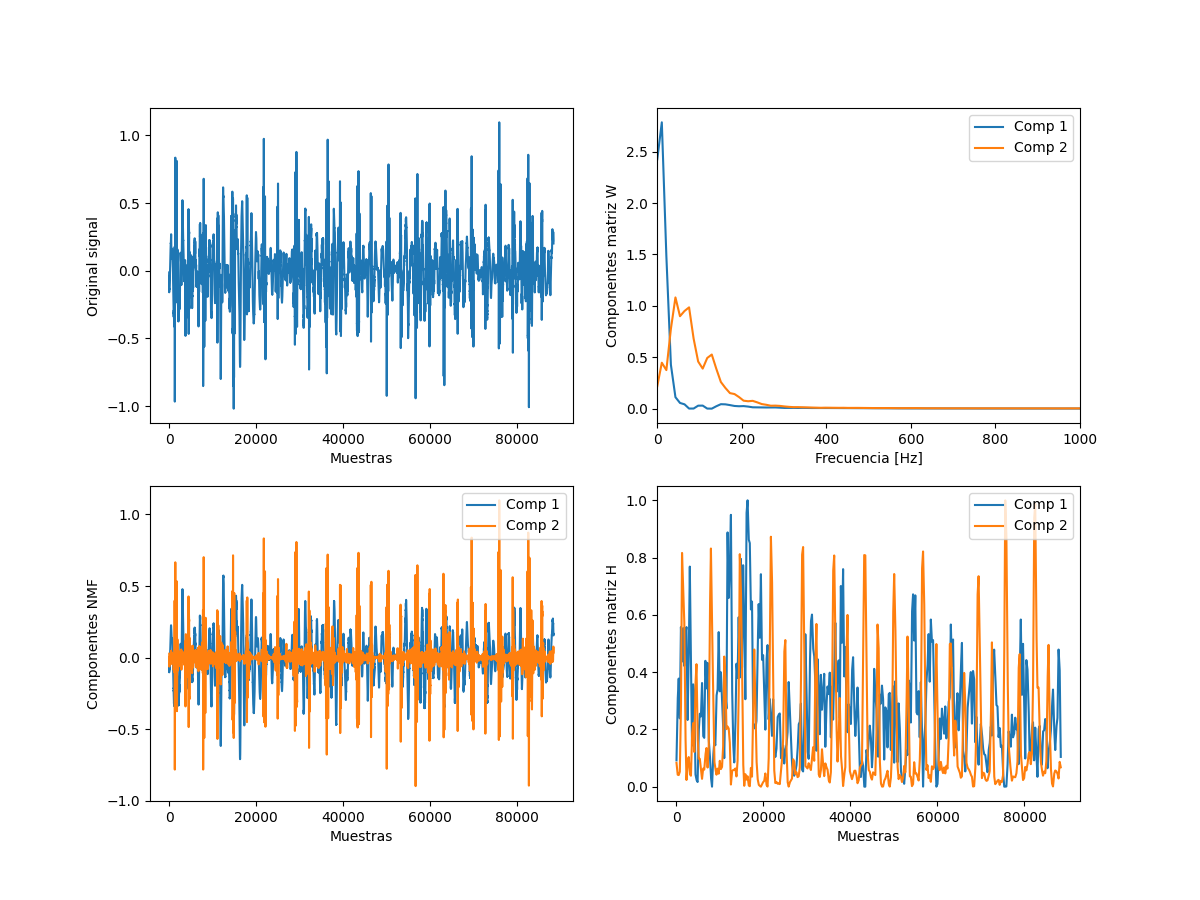

In [52]:
def graphic_nmf_to_all(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    

    ######### Separación de fuentes #########
    # Separando
    components, Y_list, S, W, H = \
            nmf_decomposition(mixed_to, samplerate_des, n_components=2, N=1024, noverlap=768, 
                              iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                              filter_out='wiener', init='random', solver='mu', beta=2,
                              tol=1e-4, max_iter=1000, alpha_nmf=0, l1_ratio=0,
                              random_state=0, W_0=None, H_0=None, same_outshape=True,
                              plot_spectrogram=False, scale='abs', db_basys=1e-15)
    
    
    plt.figure(figsize=(12, 9))
    plt.subplot(2,2,1)
    plt.plot(mixed_to)
    plt.ylabel('Original signal')
    plt.xlabel('Samples')
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    
    plt.subplot(2,2,2)
    f = [i * samplerate_des // 2 / (1024 // 2 + 1) for i in range(1024 // 2 + 1)]
    plt.plot(f, W[:,1], color='C0', label='Comp 1')
    plt.plot(f, W[:,0], color='C1', label='Comp 2')
    plt.ylabel('Matrix W components')
    plt.xlabel('Frequency [Hz]')
    plt.xlim([0, 1000])
    plt.legend(loc='upper right')
    
    plt.subplot(2,2,3)
    plt.plot(components[1], color='C0', label='Comp 1')
    plt.plot(components[0], color='C1', label='Comp 2')
    plt.ylabel('NMF components')
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    plt.xlabel('Samples')
    plt.legend(loc='upper right')
    
    plt.subplot(2,2,4)
    plt.plot(resampling_by_points(H[1], 1, N_desired=len(mixed_to)), 
             color='C0', label='Comp 1')
    plt.plot(resampling_by_points(H[0], 1, N_desired=len(mixed_to)), 
             color='C1', label='Comp 2')
    plt.ylabel('Matrix H components')
    plt.xlabel('Samples')
    plt.legend(loc='upper right')

    plt.savefig('Images/Signal plot-all.pdf', transparent=True)
    plt.show()


def graphic_nmf_to_all_spa(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    

    ######### Separación de fuentes #########
    # Separando
    components, Y_list, S, W, H = \
            nmf_decomposition(mixed_to, samplerate_des, n_components=2, N=1024, noverlap=768, 
                              iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                              filter_out='wiener', init='random', solver='mu', beta=2,
                              tol=1e-4, max_iter=1000, alpha_nmf=0, l1_ratio=0,
                              random_state=0, W_0=None, H_0=None, same_outshape=True,
                              plot_spectrogram=False, scale='abs', db_basys=1e-15)
    
    
    plt.figure(figsize=(12, 9))
    plt.subplot(2,2,1)
    plt.plot(mixed_to)
    plt.ylabel('Original signal')
    plt.xlabel('Muestras')
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    
    plt.subplot(2,2,2)
    f = [i * samplerate_des // 2 / (1024 // 2 + 1) for i in range(1024 // 2 + 1)]
    plt.plot(f, W[:,1], color='C0', label='Comp 1')
    plt.plot(f, W[:,0], color='C1', label='Comp 2')
    plt.ylabel('Componentes matriz W')
    plt.xlabel('Frecuencia [Hz]')
    plt.xlim([0, 1000])
    plt.legend(loc='upper right')
    
    plt.subplot(2,2,3)
    plt.plot(components[1], color='C0', label='Comp 1')
    plt.plot(components[0], color='C1', label='Comp 2')
    plt.ylabel('Componentes NMF')
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    plt.xlabel('Muestras')
    plt.legend(loc='upper right')
    
    plt.subplot(2,2,4)
    plt.plot(resampling_by_points(H[1], 1, N_desired=len(mixed_to)), 
             color='C0', label='Comp 1')
    plt.plot(resampling_by_points(H[0], 1, N_desired=len(mixed_to)), 
             color='C1', label='Comp 2')
    plt.ylabel('Componentes matriz H')
    plt.xlabel('Muestras')
    plt.legend(loc='upper right')

    plt.savefig('Images/Signal plot-all_SPA.pdf', transparent=True)
    plt.show()

  

%matplotlib notebook
filter_parameters = {'bool': False , 'freq_pass': 980, 'freq_stop': 1000}
nmf_parameters = {'n_components': 2, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}
snr_expected = 3

signal_index = 7
# graphic_nmf_to_all(signal_index, nmf_parameters, snr_expected, filter_parameters, 
#                    nmf_method='to_all', print_metrics=False,
#                    base_factor= 0, N_wind=100, N_expand=30)
graphic_nmf_to_all_spa(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                   nmf_method='to_all', print_metrics=False,
                   base_factor= 0, N_wind=100, N_expand=30)

# Gráfico para esquema NMF sobre segmentos

7 normal__201103090635.wav 7 2 135_2b3_Al_mc_LittC2SE.wav
SNR obtained = 9.64327466553287e-16 dB


<IPython.core.display.Javascript object>


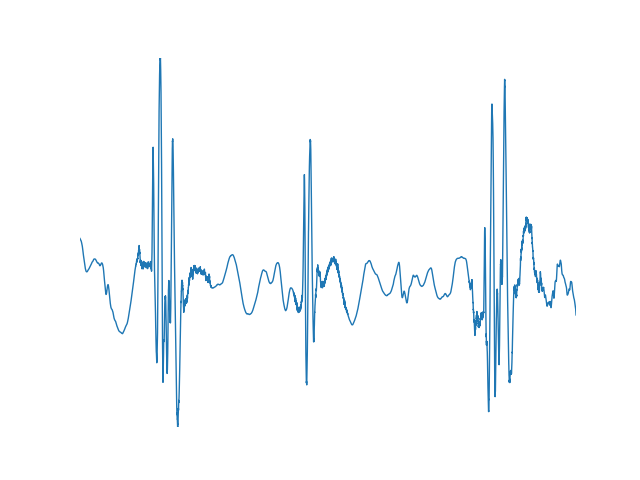

<IPython.core.display.Javascript object>


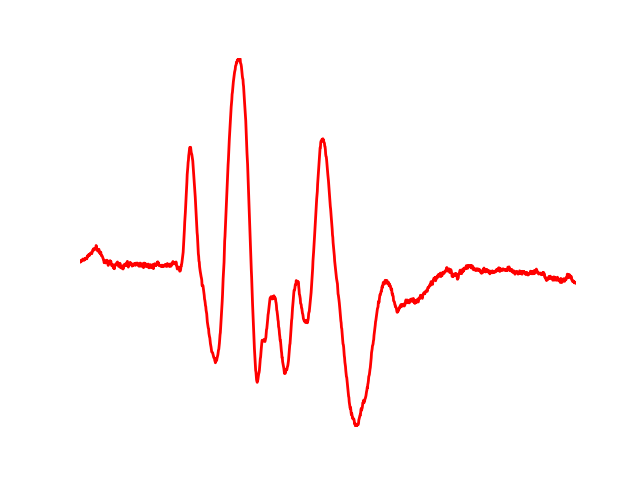

<IPython.core.display.Javascript object>


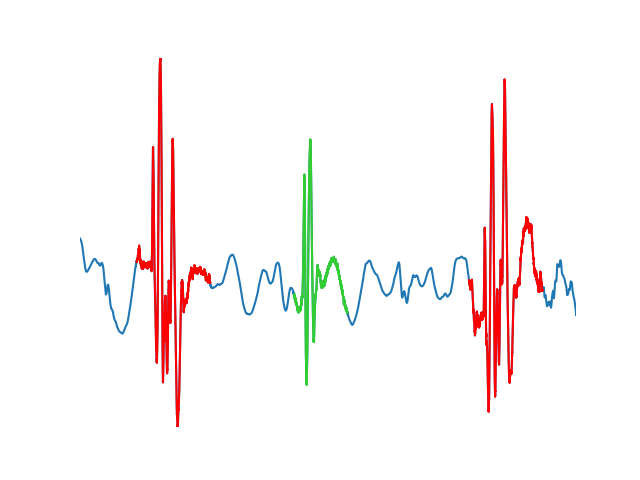

In [90]:
# Plot de señal de salida
def graphic_nmf_on_segments_to(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    

    ######### Separación de fuentes #########
    # Separando
    components, Y_list, S, W, H = \
            nmf_decomposition(mixed_to, samplerate_des, n_components=2, N=1024, noverlap=768, 
                              iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                              filter_out='wiener', init='random', solver='mu', beta=2,
                              tol=1e-4, max_iter=1000, alpha_nmf=0, l1_ratio=0,
                              random_state=0, W_0=None, H_0=None, same_outshape=True,
                              plot_spectrogram=False, scale='abs', db_basys=1e-15)
    
    # Señal zoomeada
    plt.figure()
    plt.plot(mixed_to, linewidth=1)
    plt.axis('off')
    lower_general = 20000
    upper_general = 30800
    plt.xlim([lower_general, upper_general])
    plt.ylim([min(mixed_to[lower_general:upper_general]), 
              max(mixed_to[lower_general:upper_general])])
    plt.savefig('Images/Schematics/HLS_sound.pdf', transparent=True)
    plt.show()
    
    
    # Segmento de sonido cardiorrespiratorio
    plt.figure()
    segm = 6
    plt.plot(mixed_to, color='r', linewidth=2)
    plt.axis('off')
    lower = interval_list[segm][0]
    upper = interval_list[segm][1]
    plt.xlim([lower, upper])
    plt.ylim([min(mixed_to[lower:upper]), max(mixed_to[lower:upper])])
    plt.savefig('Images/HLS_sound_segment.pdf', transparent=True)
    
    
    # Señal zoomeada destacada
    plt.figure()
    plt.plot(mixed_to)

    for num, i in enumerate(interval_list):
        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'

        # Rango en el que ploteará la señal
        x = np.arange(i[0], i[1])
        plt.plot(x, mixed_to[x], c=c_plot, linewidth=1.5)

    plt.axis('off')
    plt.xlim([lower_general, upper_general])
    plt.ylim([min(mixed_to[lower_general:upper_general]), 
              max(mixed_to[lower_general:upper_general])])
    plt.savefig('Images/HLS_sound_segment_highlight.pdf', transparent=True)
    
    


%matplotlib notebook
snr_expected = 0
signal_index = 7
graphic_nmf_on_segments_to(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                   nmf_method='to_all', print_metrics=False,
                   base_factor= 0, N_wind=100, N_expand=30)

# Gráfico para esquema NMF sobre señal completa

7 normal__201103090635.wav 7 2 135_2b3_Al_mc_LittC2SE.wav
SNR obtained = 9.64327466553287e-16 dB


<IPython.core.display.Javascript object>


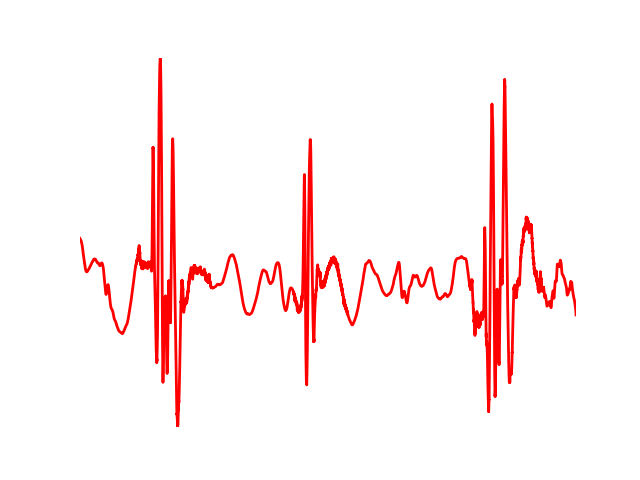

<IPython.core.display.Javascript object>


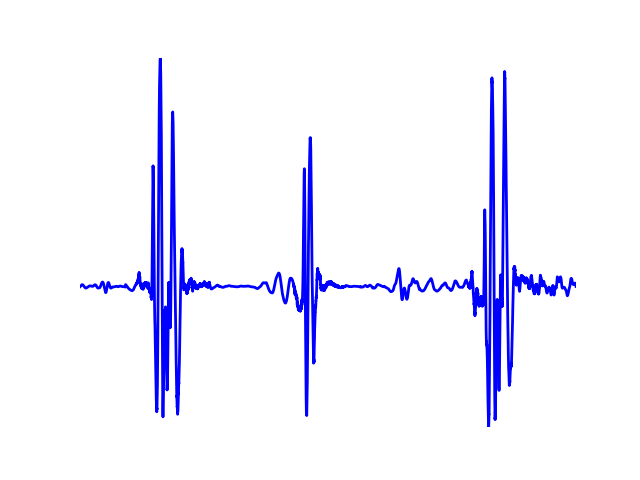

<IPython.core.display.Javascript object>


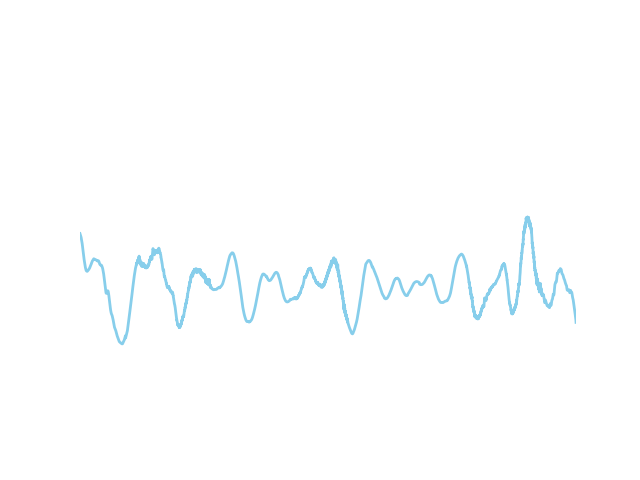

<IPython.core.display.Javascript object>


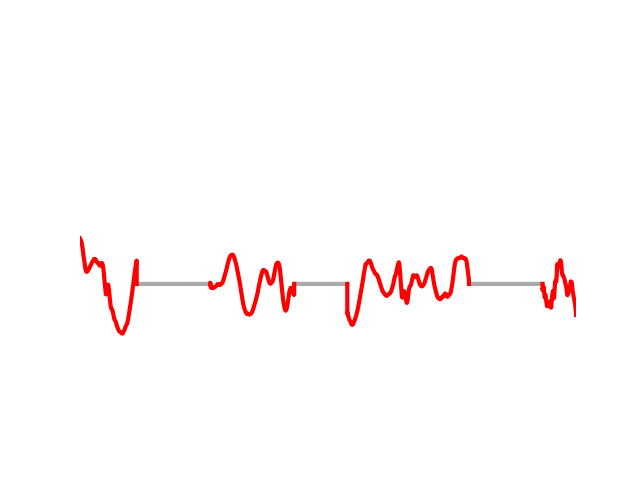

<IPython.core.display.Javascript object>


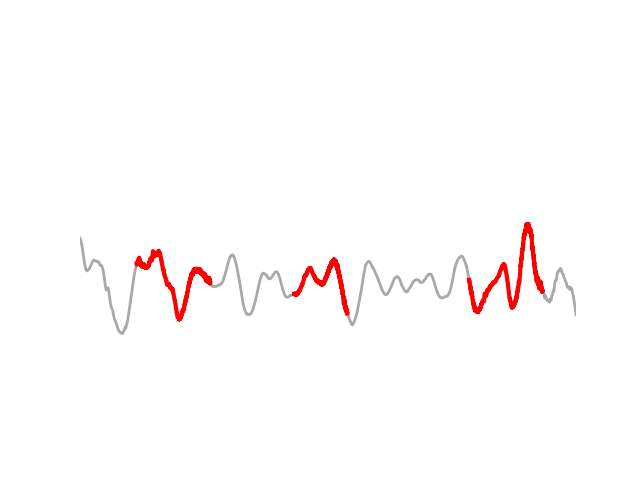

<IPython.core.display.Javascript object>


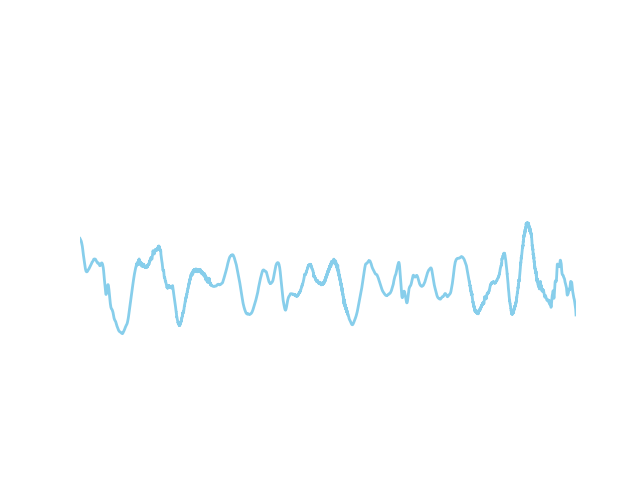

In [130]:
# Plot de señal de salida
def graphic_nmf_to_all_to(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    
    
    resp_pred, heart_pred = \
                nmf_process(mixed_to, samplerate_des, hs_pos=y_out2, 
                            interval_list=interval_list, 
                            nmf_parameters=nmf_parameters,
                            filter_parameters=filter_parameters, 
                            nmf_method=nmf_method)
    
    ######### Separación de fuentes #########
    # Separando
    components, Y_list, S, W, H = \
            nmf_decomposition(mixed_to, samplerate_des, n_components=2, N=1024, noverlap=768, 
                              iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                              filter_out='wiener', init='random', solver='mu', beta=2,
                              tol=1e-4, max_iter=1000, alpha_nmf=0, l1_ratio=0,
                              random_state=0, W_0=None, H_0=None, same_outshape=True,
                              plot_spectrogram=False, scale='abs', db_basys=1e-15)
    
    # Señal zoomeada
    plt.figure()
    plt.plot(mixed_to, linewidth=2, color='red')
    plt.axis('off')
    lower_general = 20000
    upper_general = 30800
    plt.xlim([lower_general, upper_general])
    plt.ylim([min(mixed_to[lower_general:upper_general]), 
              max(mixed_to[lower_general:upper_general])])
    plt.savefig('Images/Schematics/Original_signal.svg', transparent=True)
    plt.show()
    
    
    # Componente de sonido cardiaco
    plt.figure()
    plt.plot(components[0], color='blue', linewidth=2)
    plt.xlim([lower_general, upper_general])
    plt.ylim([min(components[0][lower_general:upper_general]), 
              max(components[0][lower_general:upper_general])])
    plt.axis('off')
    plt.savefig('Images/Schematics/Heart_normal_NMF.svg', transparent=True)
    plt.show()
    
    
    # Componente de sonido respiratorio
    plt.figure()
    plt.plot(components[1], color='skyblue', linewidth=2)
    plt.xlim([lower_general, upper_general])
    plt.ylim([min(components[0][lower_general:upper_general]), 
              max(components[0][lower_general:upper_general])])
    plt.axis('off')
    plt.savefig('Images/Schematics/Resp_normal_NMF.svg', transparent=True)
    plt.show()
    
    
    # Solo señal respiratoria    
    plt.figure()
    # Señal de salida 
    signal_to = np.copy(mixed_to)
    
    for num, i in enumerate(interval_list):
        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'
                
        # Rango en el que ploteará la señal
        x = np.arange(i[0], i[1])
        signal_to[x] = 0
        plt.plot(x, signal_to[x], c='darkgray', linewidth=3, zorder=1)
        
    
    # Variable auxiliar para definir el intervalo
    beg_seg = 0
    for num, i in enumerate(interval_list):
        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'
        
        end_seg = i[0]
        
        # Rango en el que ploteará la señal
        x = np.arange(beg_seg - 1, end_seg + 1)
        plt.plot(x, signal_to[x], c='red', linewidth=3, zorder=1)
        
        # Modificando el beg
        beg_seg = i[1]
        
    plt.axis('off')
    plt.xlim([lower_general, upper_general])
    plt.ylim([min(mixed_to[lower_general:upper_general]), 
              max(mixed_to[lower_general:upper_general])])
    
    plt.savefig('Images/Schematics/Only_Resp_NMF.svg', transparent=True)
    plt.show()
    
    
    
    # Componente Señal respiratoria destacada    
    plt.figure()
    plt.plot(components[1], color='darkgray', linewidth=2, zorder=0)

    for num, i in enumerate(interval_list):
        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'

        # Rango en el que ploteará la señal
        x = np.arange(i[0], i[1])
        plt.plot(x, components[1][x], c='red', linewidth=3, zorder=1)
    
    plt.axis('off')
    plt.xlim([lower_general, upper_general])
    plt.ylim([min(mixed_to[lower_general:upper_general]), 
              max(mixed_to[lower_general:upper_general])])
    
    plt.savefig('Images/Schematics/Comp_Resp_NMF.svg', transparent=True)
    plt.show()
    
    
    # Componente Señal respiratoria destacada    
    plt.figure()
    plt.plot(resp_pred, color='skyblue', linewidth=2, zorder=0)    
    plt.axis('off')
    plt.xlim([lower_general, upper_general])
    plt.ylim([min(mixed_to[lower_general:upper_general]), 
              max(mixed_to[lower_general:upper_general])])
    
    plt.savefig('Images/Schematics/Resp_signal_out.svg', transparent=True)
    plt.show()

    


%matplotlib notebook
snr_expected = 0
signal_index = 7

filter_parameters = {'bool': False , 'freq_pass': 980, 'freq_stop': 1000}
nmf_parameters = {'n_components': 2, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 500, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}

graphic_nmf_to_all_to(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                   nmf_method='replace_segments', print_metrics=False,
                   base_factor= 0, N_wind=100, N_expand=30)

# Espectrograma de sonido cardiaco

7 normal__201103090635.wav 7 2 135_2b3_Al_mc_LittC2SE.wav
SNR obtained = 9.64327466553287e-16 dB


<IPython.core.display.Javascript object>


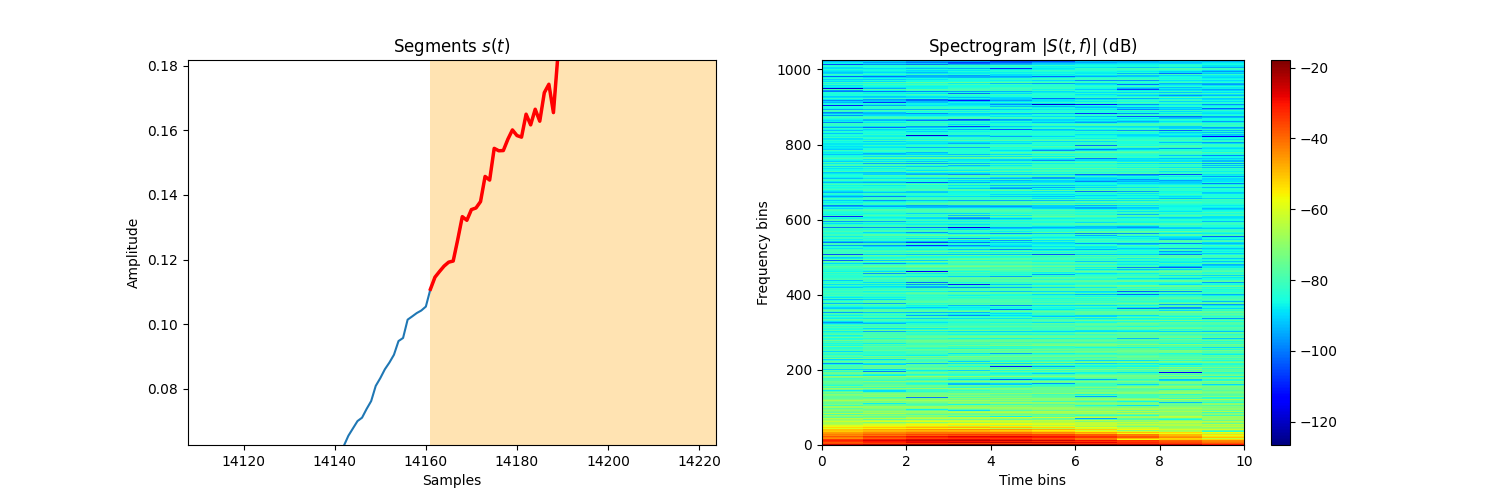

In [13]:
# Plot de señal de salida
def graphic_nmf_to_all_to(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    
    
    # Definición parámetros
    N_lax = 100
    N = 2048
    noverlap = int(0.9 * N)
    seg = 4

    seg_low = interval_list[seg][0]
    seg_upp = interval_list[seg][1]

    # Definición del límite inferior y superior
    lower = seg_low - N_lax
    upper = seg_upp + N_lax

    # Definición del segmento a transformar
    segment = mixed_to[lower:upper]

    # Plot de señal de salida
    %matplotlib notebook
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(lower,upper), segment)
    plt.plot(np.arange(seg_low , seg_upp), mixed_to[seg_low:seg_upp], c='r', linewidth=2.5)
    plt.axvspan(seg_low, seg_upp, facecolor='orange', alpha=0.3)
#     plt.xlabel('Muestras')
#     plt.ylabel('Amplitud')
#     plt.title('Segmento $s(t)$')
    
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title('Segments $s(t)$')

    # Obteniendo el espectrograma
    t, f, S = get_spectrogram(segment, samplerate_des, N=nmf_parameters['N'], 
                              padding=0, noverlap=nmf_parameters['noverlap'], 
                              window=nmf_parameters['window'], whole=False)
    
    plt.subplot(1,2,2)
    plt.pcolormesh(20 * np.log10(abs(S)), cmap='jet')
    plt.colorbar()
#     plt.xlabel('Cuadros de tiempo')
#     plt.ylabel('Cuadros de frecuencia')
#     plt.title(r'Espectrograma $|S(t,f)|$ (dB)')
#     plt.savefig('Images/Spectrogram_segment_SPA.pdf')

    plt.xlabel('Time bins')
    plt.ylabel('Frequency bins')
    plt.title(r'Spectrogram $|S(t,f)|$ (dB)')
    plt.savefig('Images/Spectrogram_segment_ENG.pdf')
    
    plt.show()
    

    

%matplotlib notebook
snr_expected = 0
signal_index = 7

filter_parameters = {'bool': False , 'freq_pass': 980, 'freq_stop': 1000}
nmf_parameters = {'n_components': 2, 'N': 2048, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': int(0.9 * 2048), 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 500, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}

graphic_nmf_to_all_to(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                   nmf_method='replace_segments', print_metrics=False,
                   base_factor= 0, N_wind=100, N_expand=30)

# Resultado para un segmento de sonido cardiaco

7 normal__201103090635.wav 7 2 135_2b3_Al_mc_LittC2SE.wav
SNR obtained = 9.64327466553287e-16 dB


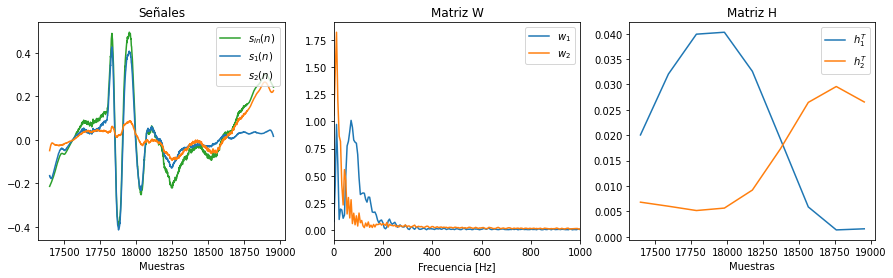

In [32]:
# Plot de señal de salida
def graphic_nmf_on_seg_to(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    
    # Definición del segmento a separar
    seg = 5

    seg_low = interval_list[seg][0]
    seg_upp = interval_list[seg][1]

    # Definición del límite inferior y superior
    lower = seg_low - nmf_parameters['N_lax']
    upper = seg_upp + nmf_parameters['N_lax']
    
    # Definición del segmento a transformar
    segment = mixed_to[lower - nmf_parameters['N_fade']:upper + nmf_parameters['N_fade']]
    
    # Realizando la descomposición
    components, Y_list, S, W, H = \
            nmf_decomposition(segment, samplerate_des, n_components=2, N=2048, noverlap=int(0.9 * 2048), 
                              iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                              filter_out='wiener', init='random', solver='mu', beta=2,
                              tol=1e-4, max_iter=1000, alpha_nmf=0, l1_ratio=0,
                              random_state=0, W_0=None, H_0=None, same_outshape=True,
                              plot_spectrogram=False, scale='abs', db_basys=1e-15)
    
    
    x = np.arange(lower - nmf_parameters['N_fade'], 
                  upper + nmf_parameters['N_fade'])
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(x, segment, color='C2', label=r'$s_{in}(n)$')
    plt.plot(x, components[0], label=r'$s_1(n)$')
    plt.plot(x, components[1], label=r'$s_2(n)$')
    plt.xlabel('Muestras')
    plt.title('Señales')
#     plt.xlabel('Samples')
#     plt.title('Signals')
    plt.legend(loc='upper right')
    
    plt.subplot(1,3,2)
    f = np.linspace(0, samplerate_des // 2 - 1, len(W[:,0]))
    plt.plot(f, W[:,0], label=r'$w_1$')
    plt.plot(f, W[:,1], label=r'$w_2$')
    plt.xlabel('Frecuencia [Hz]')
    plt.title('Matriz W')
#     plt.xlabel('Frequency [Hz]')
#     plt.title('Matrix W')
    plt.xlim([0, 1000])
    plt.legend(loc='upper right')

    plt.subplot(1,3,3)
    t = np.linspace(x[0], x[-1], len(H[0]))
    plt.plot(t, H[0], label=r'$h_1^T$')
    plt.plot(t, H[1], label=r'$h_2^T$')
    plt.xlabel('Muestras')
    plt.title('Matriz H')
#     plt.xlabel('Samples')
#     plt.title('Matrix H')
    plt.legend(loc='upper right')
    
    plt.savefig('Images/NMF_on_segs_SPA.pdf', transparent=True)
#     plt.savefig('Images/NMF_on_segs.pdf', transparent=True)
    plt.show()
    

    

%matplotlib inline
snr_expected = 0
signal_index = 7

filter_parameters = {'bool': False , 'freq_pass': 980, 'freq_stop': 1000}
nmf_parameters = {'n_components': 2, 'N': 2048, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': int(0.9 * 2048), 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 500, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}

graphic_nmf_on_seg_to(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                   nmf_method='replace_segments', print_metrics=False,
                   base_factor= 0, N_wind=100, N_expand=30)

# Resultados

## Señal original y componentes obtenidas

12 normal__201108011118.wav 12 2 226_1b1_Pl_sc_LittC2SE.wav
SNR obtained = -9.643274665532871e-16 dB


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:148: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile

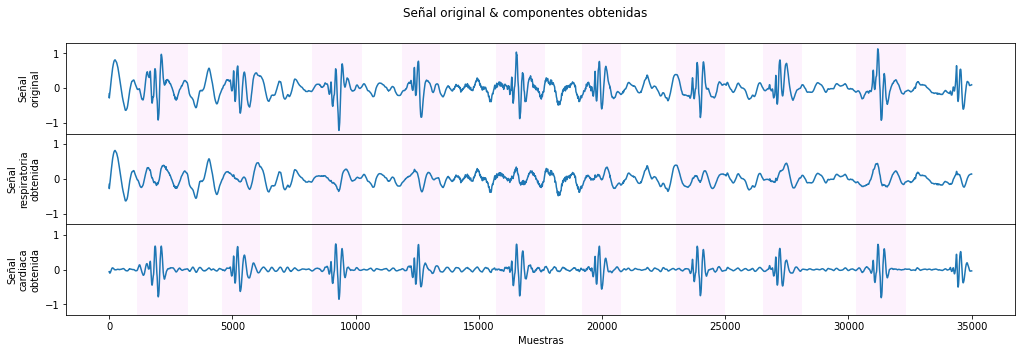

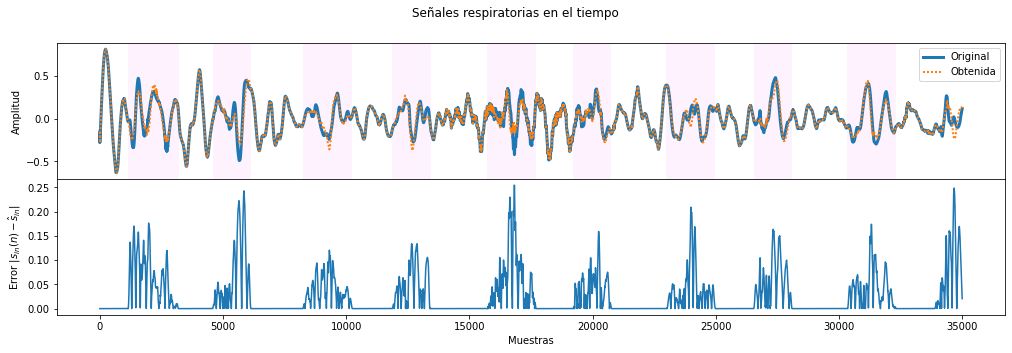

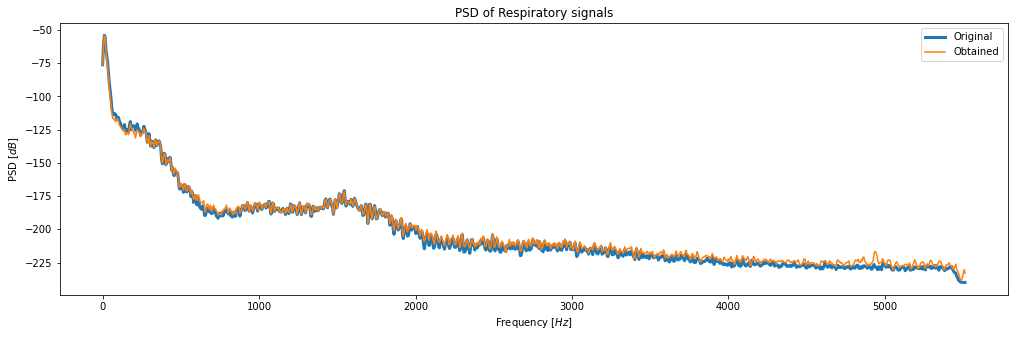

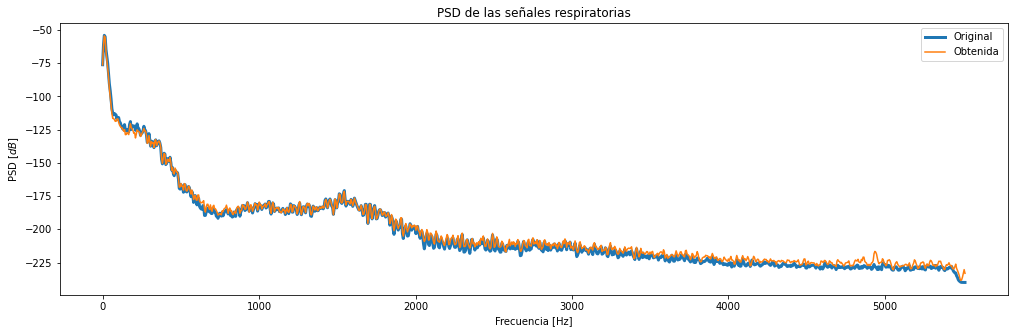

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:237: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:247: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


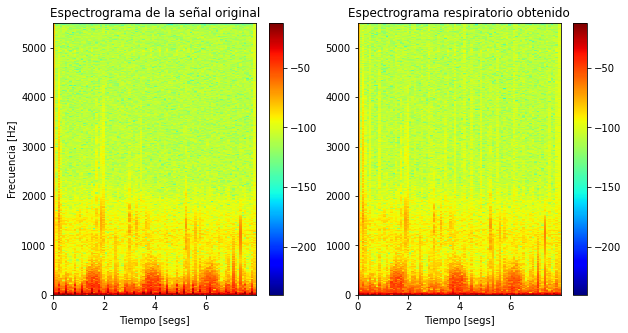

In [76]:
def graphic_results(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                              nmf_method='masked_segments', print_metrics=False,
                              base_factor= 0.05, N_wind=100, N_expand=30):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    
    def _interval_to_signal(_signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
        interval_new = list()
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(_signal_in):
                upper = len(_signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            # Lista
            interval_new.append([lower, upper])
            
        return y_out, interval_new
    
    
    ######### Import de archivos de audio #########
    samplerate_des = 11025
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index and \
           int(i[1].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
        
    print(heart_name, resp_name)
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Lecutra de la base de datos
    with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
        # Lectura del diccionario
        dict_to_rev = literal_eval(file.readline().strip())
    
    # Definición de la lista de intervalos
    interval_list = dict_to_rev[signal_index]
    
    # Definiendo la salida binaria
    y_out2, interval_list = _interval_to_signal(heart_to, interval_list,
                                                N_exp=N_expand)
    
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    
    ######### Separación de fuentes #########
    # Separando
    resp_pred, heart_pred = \
                nmf_process(mixed_to, samplerate_des, hs_pos=y_out2, 
                            interval_list=interval_list, 
                            nmf_parameters=nmf_parameters,
                            filter_parameters=filter_parameters, 
                            nmf_method=nmf_method)
    
    ### Grafico componentes ###
    
    fig, axs = plt.subplots(3, 1, figsize=(17,5), sharex=True)
    
    N_fade = nmf_parameters['N_fade']
    up_lim = 35000
    
    # Remove horizontal space between axes
    fig.subplots_adjust(hspace=0)

    plt.subplot(3,1,1)
    plt.plot(mixed_to[:up_lim])
    plt.ylabel('Señal\noriginal')
#     plt.ylabel('Original\nsignal')
    plt.tick_params(bottom=False)
    plt.xticks([])
    plt.ylim([-1.3, 1.3])

    plt.subplot(3,1,2)
    plt.plot(resp_pred[:up_lim])
    plt.tick_params(bottom=False)
    plt.xticks([])
    plt.ylabel('Señal\nrespiratoria\nobtenida')
#     plt.ylabel('Obtained\nrespiratory\nsignal')
    plt.ylim([-1.3, 1.3])

    plt.subplot(3,1,3)
    plt.plot(heart_pred[:up_lim])
    plt.xlabel('Muestras')
    plt.ylabel('Señal\ncardiaca\nobtenida')
#     plt.ylabel('Obtained\nheart\nsignal')
#     plt.xlabel('Samples')
    plt.ylim([-1.3, 1.3])

    for num, i in enumerate(interval_list):
        lower = i[0]
        upper = i[1]

        if lower >= up_lim or upper >= up_lim:
            break

        plt.subplot(3,1,1)
        plt.axvspan(lower - 2*N_fade, upper + N_fade*2, facecolor='violet', alpha=0.1)
        plt.subplot(3,1,2)
        plt.axvspan(lower - 2*N_fade, upper + N_fade*2, facecolor='violet', alpha=0.1)
        plt.subplot(3,1,3)
        plt.axvspan(lower - 2*N_fade, upper + N_fade*2, facecolor='violet', alpha=0.1)

    plt.suptitle('Señal original & componentes obtenidas')
#     plt.suptitle('Original signal & obtained components')
    plt.savefig('Images/Original_signal_and_components_SPA.pdf', transparent=True)
#     plt.savefig('Images/Original_signal_and_components.pdf', transparent=True)
    plt.show()
    
    
    ### Grafico comparación ###
    fig, axs = plt.subplots(2, 1, figsize=(17,5), sharex=True)
    
    # Remove horizontal space between axes
    fig.subplots_adjust(hspace=0)
    
    plt.subplot(2,1,1)
    plt.plot(resp_to[:up_lim], color='C0', linewidth=3, label='Original', zorder=1)
    plt.plot(resp_pred[:up_lim], color='C1', linewidth=2, linestyle=(0,(1,1)), label='Obtenida',zorder=2)
#     plt.plot(resp_pred[:up_lim], color='C1', linewidth=2, linestyle=(0,(1,1)), label='Obtained',zorder=2)
    plt.ylabel('Amplitud')
#     plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.suptitle('Señales respiratorias en el tiempo')
#     plt.suptitle('Respiratory signals on time')

    for num, i in enumerate(interval_list):
        lower = i[0]
        upper = i[1]

        if lower >= up_lim or upper >= up_lim:
            break

        plt.axvspan(lower - 2*N_fade, upper + N_fade*2, facecolor='violet', alpha=0.1)

    plt.subplot(2,1,2)
    plt.plot(abs(resp_to[:up_lim] - resp_pred[:up_lim]))    
    plt.ylabel(r'Error $|s_{in}(n) - \hat{s}_{in}|$')
    plt.xlabel('Muestras')
#     plt.xlabel('Samples')

    plt.savefig('Images/Respiratory_signals_SPA.pdf', transparent=True)
#     plt.savefig('Images/Respiratory_signals.pdf', transparent=True)
    plt.show()
    
    
    ### Gráfico PSD ###
    f1, psd1 = get_PSD(resp_to[:up_lim], samplerate_des, window='hann', 
                       N=2048, noverlap=int(0.9 * 2048))
    f2, psd2 = get_PSD(resp_pred[:up_lim], samplerate_des, window='hann', 
                        N=2048, noverlap=int(0.9 * 2048))

    plt.figure(figsize=(17,5))
    plt.plot(f1, 20 * np.log10(abs(psd1) + 1e-12), color='C0', linewidth=3, label='Original', zorder=1)
    plt.plot(f2, 20 * np.log10(abs(psd2) + 1e-12), color='C1', linewidth=1.5, label='Obtained',zorder=2)
    plt.xlabel(r'Frequency [$Hz$]')
    plt.ylabel(r'PSD [$dB$]')
    plt.legend(loc='upper right')
    plt.title('PSD of Respiratory signals')
    plt.savefig('Images/PSD_Respiratory_signals.pdf', transparent=True)
    plt.show()
    
    plt.figure(figsize=(17,5))
    plt.plot(f1, 20 * np.log10(abs(psd1) + 1e-12), color='C0', linewidth=3, label='Original', zorder=1)
    plt.plot(f2, 20 * np.log10(abs(psd2) + 1e-12), color='C1', linewidth=1.5, label='Obtenida',zorder=2)
    plt.xlabel(r'Frecuencia [Hz]')
    plt.ylabel(r'PSD [$dB$]')
    plt.legend(loc='upper right')
    plt.title('PSD de las señales respiratorias')
    plt.savefig('Images/PSD_Respiratory_signals_SPA.pdf', transparent=True)
    plt.show()
    
    ### Gráfico de los espectrogramas ###
    fup_lim = -1
    N = 1024
    t1, f1, S1 = get_spectrogram(mixed_to, samplerate_des, N=N, padding=0, noverlap=int(0.9)*N, 
                                 window='hann', whole=False)
    t2, f2, S2 = get_spectrogram(resp_pred, samplerate_des, N=N, padding=0, noverlap=int(0.9)*N, 
                                 window='hann', whole=False)

    vmin = np.min((20 * np.log10(abs(S1[:fup_lim,:]) + 1e-12),
                  20 * np.log10(abs(S2[:fup_lim,:]) + 1e-12)))
    vmax = np.max((20 * np.log10(abs(S1[:fup_lim,:]) + 1e-12),
               20 * np.log10(abs(S2[:fup_lim,:]) + 1e-12)))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.pcolormesh(t1, f1[:fup_lim], 20 * np.log10(abs(S1[:fup_lim,:]) + 1e-12), cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar()
#     plt.xlabel('Time [secs]')
#     plt.ylabel('Frequency [Hz]')
#     plt.title('Original signal spectrogram')
    plt.xlabel('Tiempo [segs]')
    plt.ylabel('Frecuencia [Hz]')
    plt.title('Espectrograma de la señal original')
    
    plt.subplot(1,2,2)
    plt.pcolormesh(t2, f2[:fup_lim], 20 * np.log10(abs(S2[:fup_lim,:]) + 1e-12), cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar()
#     plt.xlabel('Time [secs]')
#     plt.title('Respiratory obtained spectrogram')
    plt.xlabel('Tiempo [segs]')
    plt.title('Espectrograma respiratorio obtenido')

#     plt.savefig('Images/Original_and_respiratory_spectrogram.png', transparent=True)
    plt.savefig('Images/Original_and_respiratory_spectrogram_SPA.png', transparent=True)
    plt.show()
        
    

%matplotlib inline
snr_expected = 0
signal_index = 12

filter_parameters = {'bool': False , 'freq_pass': 980, 'freq_stop': 1000}
nmf_parameters = {'n_components': 10, 'N': 2048, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': int(0.9 * 2048), 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 2, 'tol': 1e-4, 
                  'max_iter': 500, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'temp_criterion'}

graphic_results(signal_index, nmf_parameters, snr_expected, filter_parameters, 
                   nmf_method='replace_segments', print_metrics=False,
                   base_factor= 0, N_wind=100, N_expand=30)